In [40]:
import json
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, roc_curve
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
from sklearn.base import clone
import gmaps
import os
from itertools import chain
from collections import Counter
import cnfg

%matplotlib inline
sns.set_style("whitegrid")
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

In [41]:
config = cnfg.load(".metis_config")
engine = create_engine('postgresql://{}:{}@{}:5432/{}'.format(
            config['db_user'],
            config['db_pwd'],
            config['db_host'],
            'ubuntu'))

conn = engine.connect()
query = 'SELECT * FROM kiva_loan_view'
df = pd.read_sql_query(query, conn)

## Data Train/Test Split

Use K-Fold sampling to get training and test data from table `loan_view`:
- `X_train`, `X_test`
- `y_train`, `y_test`

Around 8% of loans 'expired' (positive class).

In [59]:
# Get training data X and labels y
y_col = 'status'
X_columns = df.columns.drop([y_col])
X = df.loc[:, X_columns]

# Expired Status = Positive Class (i.e. y=1)
y_status = df[y_col] 
y = y_status.map(lambda status: 1 if (status == 'expired') else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=55)

# Check if stratified K-Fold sampling worked correctly
train_data_count = y_train.shape[0]
test_data_count = y_test.shape[0]

print("""# Training points: {}, # Test points: {}
% Loans expired in training data: {}
% Loans expired in test data: {}
\nFeatures:\n{}""".format(
    train_data_count, test_data_count,
    y_train[y_train == 1].shape[0] / train_data_count,
    y_test[y_test == 1].shape[0] / test_data_count,
    X_train.columns.values)
)
X_train.describe()

# Training points: 63551, # Test points: 21184
% Loans expired in training data: 0.08053374455161996
% Loans expired in test data: 0.08053247734138973

Features:
['id' 'name' 'funded_amount' 'funded_date' 'planned_expiration_date'
 'posted_date' 'sector' 'activity' 'loan_amount' 'lender_count' 'country'
 'country_code' 'town' 'latitude' 'longitude' 'bonus_credit_eligibility'
 'description' 'use_text' 'tag_text' 'terms_disbursal_amount'
 'terms_disbursal_currency' 'terms_disbursal_date' 'terms_loan_amount'
 'terms_loss_liability_nonpayment' 'terms_repayment_term'
 'journal_totals_entries' 'borrower_count' 'm_borrower_count'
 'f_borrower_count' 'pic_borrower_count']


,id,funded_amount,loan_amount,lender_count,latitude,longitude,terms_disbursal_amount,terms_loan_amount,terms_repayment_term,journal_totals_entries,borrower_count,m_borrower_count,f_borrower_count,pic_borrower_count
count,6.355100e+04,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,6.355100e+04,63551.000000,63551.000000,63551.0,63551.000000,63551.000000,63551.000000,63551.000000
mean,1.086020e+06,763.520244,819.767195,20.073516,10.658339,33.646768,1.189249e+06,819.767195,13.575270,0.0,1.980567,0.399569,1.580998,1.948577
std,3.079779e+04,1113.542627,1151.308639,26.982058,14.823680,80.499433,5.585610e+06,1151.308639,7.945217,0.0,3.200214,1.040144,2.891592,3.059185
min,1.017905e+06,0.000000,25.000000,0.000000,-30.000000,-172.616667,1.000000e+02,25.000000,2.000000,0.0,1.000000,0.000000,0.000000,1.000000
25%,1.057834e+06,250.000000,275.000000,7.000000,1.000000,-57.996389,5.500000e+03,275.000000,8.000000,0.0,1.000000,0.000000,1.000000,1.000000
50%,1.092222e+06,425.000000,475.000000,12.000000,13.000000,38.000000,2.000000e+04,475.000000,13.000000,0.0,1.000000,0.000000,1.000000,1.000000
75%,1.113756e+06,825.000000,925.000000,23.000000,13.833333,122.000000,1.000000e+05,925.000000,14.000000,0.0,1.000000,1.000000,1.000000,1.000000
max,1.140926e+06,50000.000000,50000.000000,1626.000000,49.783333,159.000000,1.300000e+08,50000.000000,145.000000,0.0,44.000000,28.000000,41.000000,44.000000


## Data Exploration

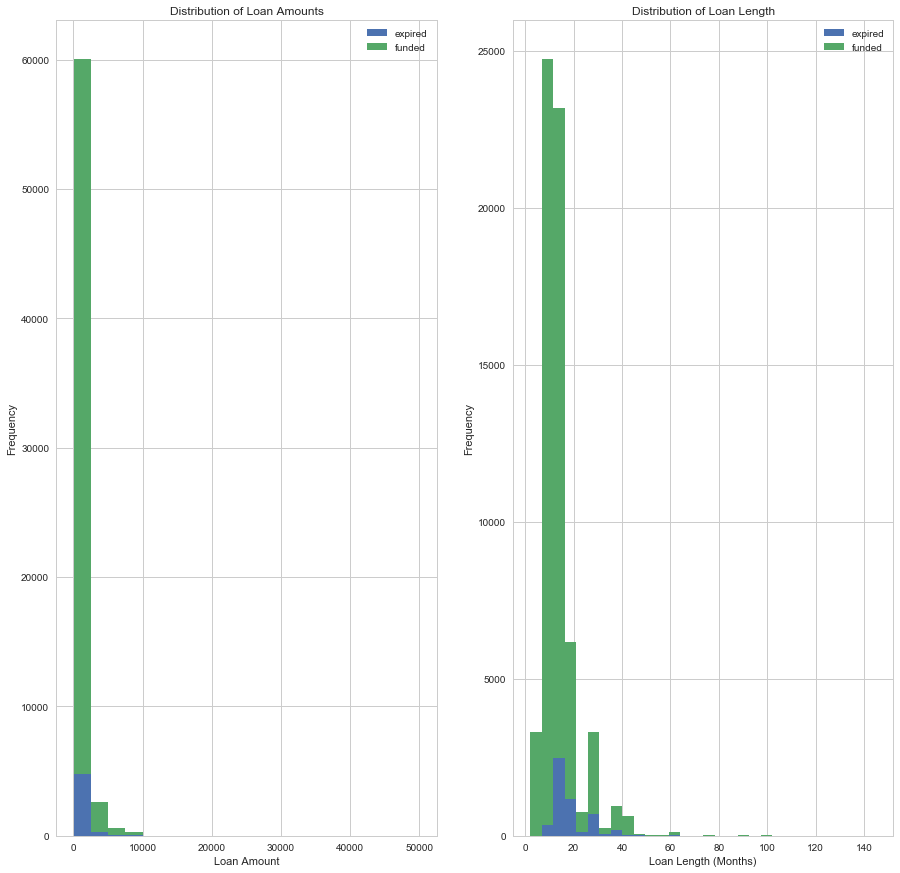

In [43]:
def initial_data_explore(data_expired, data_funded):
    """
    Plot frequencies vs features grouped by expired or funded status
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 15))

    # Loan Amounts
    pd.DataFrame({
        'expired': data_expired.loan_amount,
        'funded': data_funded.loan_amount
    }).plot.hist(ax=ax[0], stacked=True, bins=20)

    ax[0].set_title('Distribution of Loan Amounts')
    ax[0].set_ylabel('Frequency')
    ax[0].set_xlabel('Loan Amount')

    # Loan Length (Repayment Term)
    pd.DataFrame({
        'expired': data_expired[~np.isnan(data_expired.repayment_term)].repayment_term,
        'funded': data_funded[~np.isnan(data_funded.repayment_term)].repayment_term
    }).plot.hist(ax=ax[1], stacked=True, bins=30)

    ax[1].set_title('Distribution of Loan Length')
    ax[1].set_ylabel('Frequency')
    ax[1].set_xlabel('Loan Length (Months)')

train_status = pd.DataFrame({'loan_amount': X_train.loan_amount,
                          'repayment_term': X_train.terms_repayment_term,
                          'country': X_train.country,
                          'sector': X_train.sector, 
                          'status': y_train})
train_expired = train_status.groupby('status').get_group(1)
train_funded = train_status.groupby('status').get_group(0)

initial_data_explore(train_expired, train_funded)

## Data Cleaning & Engineering

Don't use features `funded_date` and `lender_count` because these would cause data leakage.

Define variables 
- `df_status_country`: Loan Count and % Expired by Sector
- `df_status_sector`: Loan Count and % Expired by Country
- `train_medians`: Impute median into columns with missing records

In [48]:
def get_loan_status(data_status, groupby_feature):
    """Get loan count and percent expired by sector, country, etc in data"""
    df_status_by_feature = data_status.groupby(['status', groupby_feature]).count().reset_index()
    df_status_by_feature = df_status_by_feature.pivot(index=groupby_feature, columns='status', values='loan_amount')
    df_status_by_feature = df_status_by_feature.fillna(0).reset_index()
    df_status_by_feature = df_status_by_feature.set_index([groupby_feature])
    df_status_by_feature['total_loan_count'] = df_status_by_feature[0] + df_status_by_feature[1]
    df_status_by_feature['percent_expired'] =  df_status_by_feature[1] / df_status_by_feature['total_loan_count']
    return df_status_by_feature

df_status_sector = get_loan_status(train_status, 'sector')
df_status_country = get_loan_status(train_status, 'country')
train_medians = X_train.median()

In [49]:
df_status_sector.head()

status,0,1,total_loan_count,percent_expired
sector,,,,
Agriculture,16483.0,1654.0,18137.0,0.091195
Arts,1212.0,6.0,1218.0,0.004926
Clothing,2657.0,350.0,3007.0,0.116395
Construction,496.0,23.0,519.0,0.044316
Education,2467.0,33.0,2500.0,0.013200


In [45]:
df_status_country.head()

Loan Status by Country:


status,0,1,total_loan_count,percent_expired
country,,,,
Albania,124.0,27.0,151.0,0.178808
Armenia,779.0,281.0,1060.0,0.265094
Azerbaijan,125.0,21.0,146.0,0.143836
Belize,17.0,0.0,17.0,0.000000
Bolivia,812.0,161.0,973.0,0.165468


Some Kiva loans have tags in their listings. E.g. 'education', 'female', etc.
See if having these tags helps to get funding.

Calculate `tag_text_to_prob` which is how frequently the top 25 words in funded loans appears.

In [68]:
def map_tag_to_probabiltiy():
    X_train['text_tag_clean'] = X_train['tag_text'].str.strip()

    # Array of funded loans' tags
    df_tag_text_funded = X_train.loc[(y_train==0), 'text_tag_clean'].as_matrix()
    tag_words_funded = list(chain.from_iterable([str(tag_text).split(' ') for tag_text in df_tag_text_funded]))

    # Dictionary of tag to # times it appeared
    # E.g. { '#Animals': 7645 .. }
    tag_words_funded_counts = Counter(tag_words_funded)
    
    # Get dictionary of most common 25 words in funded loans
    tag_words_counts_list = tag_words_funded_counts.most_common()[25:]
    
    total_counts = sum(tag_count for tag_text, tag_count in tag_words_counts_list)
    prob_mapping = {}
    for tag_text, tag_count in tag_words_counts_list:
        clean_tag = tag_text.lower().replace('#', '') 
        prob_mapping[clean_tag] = tag_count / total_counts
    return prob_mapping

# Mapping of tag to probability of appearing in funded loans
# {'ag': 0.057885906040268456,
# 'creator': 0.04229174891433083}
tag_text_to_prob = map_tag_to_probabiltiy()

In [69]:
def calc_tag_fund_prob(tag_text):
    clean_tag_text = tag_text.lower().replace('#', '') 
    tags = clean_tag_text.split(' ')
    prob = sum([tag_text_to_prob.get(tag_word, 0) for tag_word in tags])
    return prob
    
X_train['tag_text_fund_prob'] = X_train['tag_text'].map(calc_tag_fund_prob)

In [70]:
train_medians.head()

id               1092222.0
funded_amount    425.0    
loan_amount      475.0    
lender_count     12.0     
latitude         13.0     
dtype: float64

In [73]:
def loan_clean_engineer(row):
    """Impute training data for missing records"""
    
    row['already_disbursed'] = False
    
    if row.terms_disbursal_date and (row.posted_date >= row.terms_disbursal_date):
        row.already_disbursed = True
    
    # Percentage of Women Borrowers
    row['percentage_women'] = 0
    if row.f_borrower_count > 0:
        row.percentage_women = 100 * (row.f_borrower_count / row.borrower_count)
    
    # Sector's expiration %, default is median % expired for sector 
    sector = row.sector
    sector_percent_expired_median = train_medians['sector_percent_expired'] 
    row['sector_percent_expired'] = sector_percent_expired_median
    if sector:
        sector_percent_expired = df_status_sector['percent_expired'].get(sector, None)
        if sector_percent_expired:
            row.sector_percent_expired = sector_percent_expired
        
    country = row.country
    
    # Country's expiration rate
    # Default is median % expired for country
    row['country_percent_expired'] = train_medians['country_percent_expired']
    country_percent_expired = df_status_country['percent_expired'].get(country, None)
    country_total_loan_count = df_status_country['total_loan_count'].get(country, None)
    if country_percent_expired:
        row.country_percent_expired = country_percent_expired
        
    row['country_total_loans'] = train_medians['country_total_loans'] # median loan count for country
    if country_total_loan_count:
        row.country_total_loans = country_total_loan_count
    
    row['description_word_count'] = 0 # default length = 0
    if (row.description):
        row.description_word_count = len(row.description.split(' '))
        
    # See if loan contains tags that are indicitive of funding
    row['tag_text_fund_prob'] = train_medians['tag_text_fund_prob'] # default
    if (row.tag_text):
        row.tag_text_fund_prob = calc_tag_fund_prob(row.tag_text)
  
    return row

def clean_engineer_dataset(data_df):
    data_df = data_df.apply(loan_clean_engineer, axis=1)
    return data_df

X_train = clean_engineer_dataset(X_train)

# Only impute test set with training data
X_test = clean_engineer_dataset(X_test) 
X_train.describe()

,id,funded_amount,loan_amount,lender_count,latitude,longitude,terms_disbursal_amount,terms_loan_amount,terms_repayment_term,journal_totals_entries,borrower_count,m_borrower_count,f_borrower_count,pic_borrower_count,tag_text_fund_prob,percentage_women,sector_percent_expired,country_percent_expired,country_total_loans,description_word_count
count,6.355100e+04,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,6.355100e+04,63551.000000,63551.000000,63551.0,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000
mean,1.086020e+06,763.520244,819.767195,20.073516,10.658339,33.646768,1.189249e+06,819.767195,13.575270,0.0,1.980567,0.399569,1.580998,1.948577,0.068339,77.116290,0.080598,0.082102,5726.175560,120.522572
std,3.079779e+04,1113.542627,1151.308639,26.982058,14.823680,80.499433,5.585610e+06,1151.308639,7.945217,0.0,3.200214,1.040144,2.891592,3.059185,0.083796,40.633814,0.028903,0.068828,6273.019041,52.103303
min,1.017905e+06,0.000000,25.000000,0.000000,-30.000000,-172.616667,1.000000e+02,25.000000,2.000000,0.0,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.001876,0.003636,1.000000,0.000000
25%,1.057834e+06,250.000000,275.000000,7.000000,1.000000,-57.996389,5.500000e+03,275.000000,8.000000,0.0,1.000000,0.000000,1.000000,1.000000,0.000000,78.260870,0.071584,0.020401,933.000000,85.000000
50%,1.092222e+06,425.000000,475.000000,12.000000,13.000000,38.000000,2.000000e+04,475.000000,13.000000,0.0,1.000000,0.000000,1.000000,1.000000,0.000000,100.000000,0.091195,0.057878,2477.000000,108.000000
75%,1.113756e+06,825.000000,925.000000,23.000000,13.833333,122.000000,1.000000e+05,925.000000,14.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.107580,100.000000,0.092048,0.116331,16127.000000,145.000000
max,1.140926e+06,50000.000000,50000.000000,1626.000000,49.783333,159.000000,1.300000e+08,50000.000000,145.000000,0.0,44.000000,28.000000,41.000000,44.000000,0.619572,100.000000,0.138451,0.265094,16127.000000,825.000000


## Post Data-Engineering Analysis

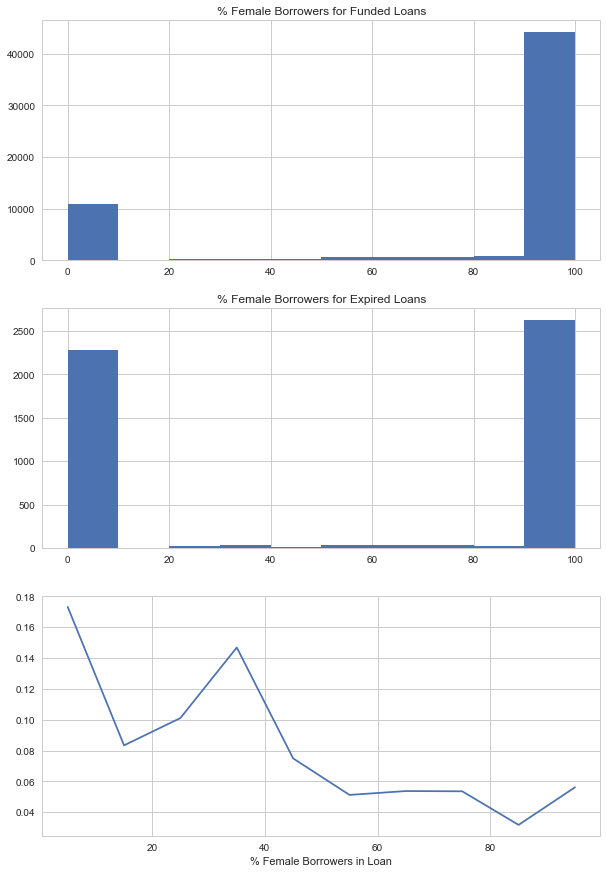

In [74]:
# Ignore description text length, no correlation
fig, ax = plt.subplots(3, 1, figsize=(10, 15)) 
count0, bins_0, _ = ax[0].hist(X_train.loc[(y_train==0), 'percentage_women'], bins=10, range=(0,100))
count1, bins_1, _ = ax[1].hist(X_train.loc[(y_train==1), 'percentage_women'], bins=10, range=(0,100))
ax[0].set_title('Frequency of % Female Borrowers for Funded Loans')
ax[1].set_title('Frequency % Female Borrowers for Expired Loans')
ax[2].plot((bins_0[:-1]+bins_0[1:])/2, count1/(count1 + count0))
ax[2].set_xlabel('% Female Borrowers in Loan')


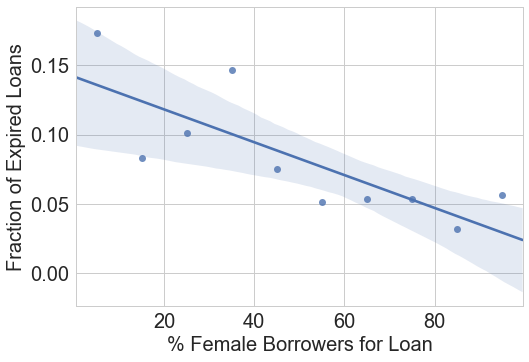

In [62]:
sns.regplot((bins_0[:-1]+bins_0[1:])/2, count1/(count1 + count0))
plt.ylabel('Fraction of Expired Loans', fontsize=20)
plt.xlabel('% Female Borrowers for Loan', fontsize=20)

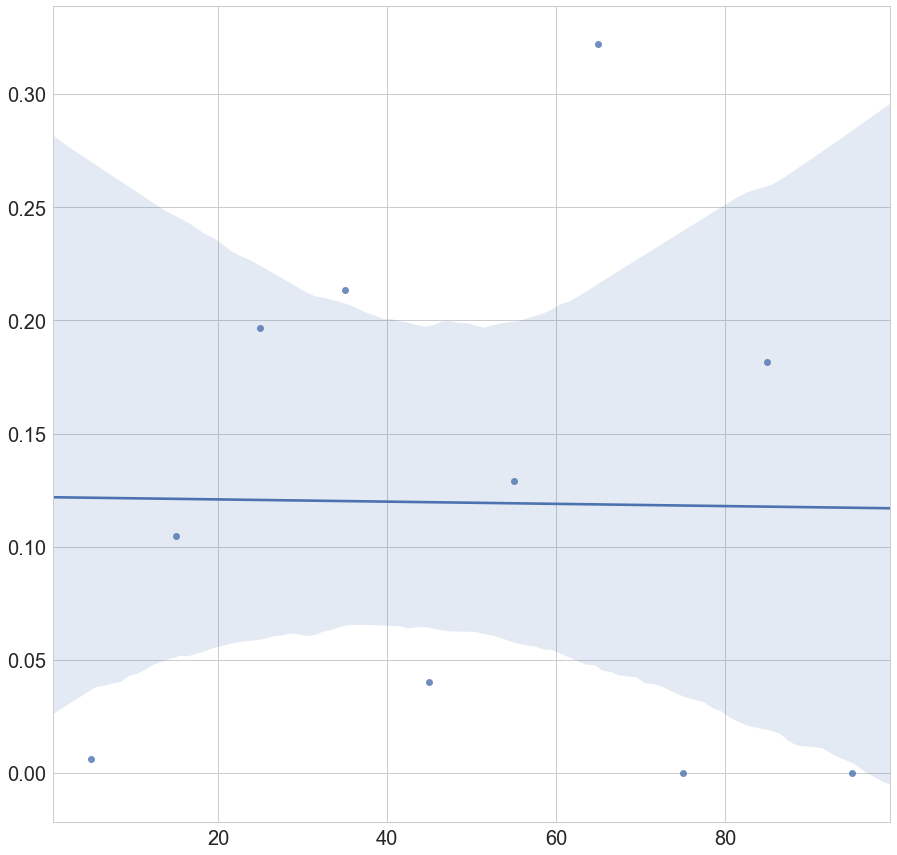

In [93]:
# Ignore description text length, no correlation
count0_loan_length, bins_0_loan_length, _ = ax[0].hist(X_train.loc[(y_train==0), 'terms_repayment_term'], bins=10, range=(0,100))
count1_loan_length, bins_1_loan_length, _ = ax[1].hist(X_train.loc[(y_train==1), 'terms_repayment_term'], bins=10, range=(0,100))
sns.regplot((bins_0_loan_length[:-1]+bins_0_loan_length[1:])/2, count1_loan_length/(count1_loan_length + count0_loan_length))

## Helper Functions

In [14]:
def order_zip_coeff(coeff_names, coeff_vals):
    coeff_names = np.array(coeff_names)
    coeff_vals = np.array(coeff_vals)
    importance_indices = np.argsort(coeff_vals)[::-1]
    return list(enumerate(zip(coeff_names[importance_indices], coeff_vals[importance_indices])))


def cross_val_predict_proba(model, X, y, folds=5, verbose=True):
    """
    Function like “cross_val_predict” except using `predict_proba`. 
    May be useful if you want to do cross-validation or grid-search, but using ROC_AUC 
    instead of accuracy or some other metric.
    """
    this_model = clone(model)
    num_classes = len(np.unique(y))
    y_pred = np.zeros((len(y),num_classes))
    skf = StratifiedKFold(n_splits=folds, shuffle=True).split(X, y)
    for idx, (train_idx, test_idx) in enumerate(skf):
        if verbose:
            print("training fold {} of {}".format(idx+1, folds))
        X_train = np.array(X)[train_idx,:]
        X_test = np.array(X)[test_idx,:]
        y_train = np.array(y)[train_idx]        
        this_model.fit(X_train,y_train)
        y_pred[test_idx,:] = this_model.predict_proba(X_test)
    return y_pred

def metric_curves(truthvec, scorevec, digit_prec=2):
    threshvec = np.unique(np.round(scorevec,digit_prec))
    numthresh = len(threshvec)
    tpvec = np.zeros(numthresh)
    fpvec = np.zeros(numthresh)
    fnvec = np.zeros(numthresh)
    
    accuracyvec = np.zeros(numthresh)
    f1vec = np.zeros(numthresh)
    
    for i in range(numthresh):
        thresh = threshvec[i]
        pos_pred = (scorevec >= thresh)
        neg_pred = (scorevec < thresh)
        tpvec[i] = sum(truthvec[pos_pred])
        fpvec[i] = sum(1 - truthvec[pos_pred])
        fnvec[i] = sum(truthvec[neg_pred])
        
        predvec = [1 if pred_pos else 0 for pred_pos in pos_pred]
        accuracyvec[i] = accuracy_score(truthvec, predvec)
        f1vec[i] = f1_score(truthvec, predvec)
        
    recallvec = tpvec / (tpvec + fnvec)
    precisionvec = tpvec / (tpvec + fpvec)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Precision vs Thresholds and Recall vs Thresholds
    ax.plot(threshvec, precisionvec, label='Precision')
    ax.plot(threshvec, recallvec, label='Recall')
    ax.plot(threshvec, accuracyvec, label='Accuracy')
    ax.plot(threshvec, f1vec, label='F1')
    ax.axis([0, 1, 0, 1])
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Precision / Recall / Accuracy / F1")
    ax.legend()
    
    return (recallvec, precisionvec, threshvec)

def print_metrics(model_name, y_actual_test, y_pred_proba):
    auc_score = roc_auc_score(y_actual_test, y_pred_proba)
    l_loss = log_loss(y_actual_test, y_pred_proba)
    print('--- ', model_name, ' ---')
    print('AUC: ', auc_score)
    print('Log Loss: ', l_loss)
    recallvec, precisionvec, threshvec = metric_curves(y_actual_test, y_pred_proba, digit_prec=2)
    return (recallvec, precisionvec, threshvec, auc_score, l_loss)
    

In [15]:
def example_calc():
    pos_pred = np.array([True, False, True, False])
    truthvec = np.array([1, 0, 0, 1])
    tpvec = truthvec[pos_pred]
    fpvec = 1 - tpvec
    
    neg_pred = np.array([False, True, False, True]) # Opposite
    fnvec = truthvec[neg_pred]
    print('Predicted positives (Indices 0, 2):', tpvec, ', Actual Pos (Indice 0), ', 'True Pos Count: ', sum(tpvec))
    print('False positives: ', fpvec, '(Indice 2), False Pos Count: ', sum(fpvec))
    print('False negatives: ', fnvec, '(Indices 1, 3), False Neg Count: ', sum(fnvec))
example_calc()    

Predicted positives (Indices 0, 2): [1 0] , Actual Pos (Indice 0),  True Pos Count:  1
False positives:  [0 1] (Indice 2), False Pos Count:  1
False negatives:  [0 1] (Indices 1, 3), False Neg Count:  1


## KNN
Use KNN as a feature input to another model to capture interaction effects. Also KNN suffers heavily from curse of dimensionality.

Fitted k=118, Log Loss: 0.22704920411170876
Fitted k=120, Log Loss: 0.22908988653394502
Fitted k=122, Log Loss: 0.22457861030879567
Fitted k=124, Log Loss: 0.22136030209973323
Fitted k=126, Log Loss: 0.22754727058971863
Fitted k=128, Log Loss: 0.22417311583833385
Fitted k=130, Log Loss: 0.2234791063858942
Fitted k=132, Log Loss: 0.2270879556514332
Fitted k=134, Log Loss: 0.22524306854506285
Fitted k=136, Log Loss: 0.22100764805311532
Fitted k=138, Log Loss: 0.23223081166842985


[(136, 0.22100764805311532),
 (124, 0.22136030209973323),
 (130, 0.22347910638589419),
 (128, 0.22417311583833385),
 (122, 0.22457861030879567),
 (134, 0.22524306854506285),
 (118, 0.22704920411170876),
 (132, 0.22708795565143319),
 (126, 0.22754727058971863),
 (120, 0.22908988653394502),
 (138, 0.23223081166842985)]

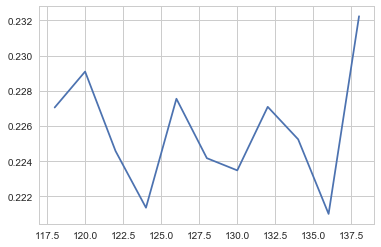

In [16]:
knn_cols = ['loan_amount',  'latitude', 'longitude']
knn_log_loss_scores = []

std_knn = StandardScaler()
std_knn.fit(X_train.loc[:, knn_cols])

X_std_train_knn = std_knn.transform(X_train.loc[:, knn_cols])
X_std_test_knn = std_knn.transform(X_test.loc[:, knn_cols])

for k in range(118, 140, 2):
    knn_model_k = KNeighborsClassifier(n_neighbors=k)
    y_cross_val_pred_proba_knn = cross_val_predict_proba(knn_model_k, X_std_train_knn, y_train, verbose=False)[:, 1]
    k_log_loss = log_loss(y_train, y_cross_val_pred_proba_knn)
    print('Fitted k={}, Log Loss: {}'.format(k, k_log_loss))
    knn_log_loss_scores.append((k, k_log_loss))

knn_log_loss_scores.sort(key=lambda x: x[0], reverse=False)
plt.plot(range(118, 140, 2), [log_loss for knn, log_loss in knn_log_loss_scores])

knn_log_loss_scores.sort(key=lambda x: x[1], reverse=False)
knn_log_loss_scores[:30]

---  KNN, K=124  ---
AUC:  0.840060665431
Log Loss:  0.222922024144


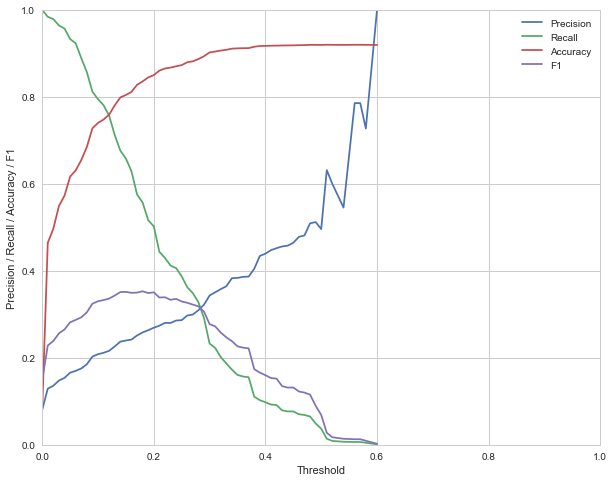

In [17]:
k=124
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_std_train_knn, y_train)
y_test_pred_proba_knn = knn_model.predict_proba(X_std_test_knn)[:, 1]

model_name_knn = 'KNN, K={}'.format(k)
recallvec_knn, precisionvec_knn, threshvec_knn, auc_score_knn, l_loss_knn = print_metrics (
    model_name_knn, y_test, y_test_pred_proba_knn)

### Use KNN Prediction as a Feature

In [18]:
y_train_pred_proba_knn = knn_model.predict_proba(X_std_train_knn)[:, 1]

X_train['knn_pred'] = y_train_pred_proba_knn
X_test['knn_pred'] = y_test_pred_proba_knn

In [19]:
print('All columns (including engineered features): {}'.format(X_train.columns.values))
X_train.describe()

All columns (including engineered features): ['id' 'name' 'funded_amount' 'funded_date' 'planned_expiration_date'
 'posted_date' 'sector' 'activity' 'loan_amount' 'lender_count' 'country'
 'country_code' 'town' 'latitude' 'longitude' 'bonus_credit_eligibility'
 'description' 'use_text' 'tag_text' 'terms_disbursal_amount'
 'terms_disbursal_currency' 'terms_disbursal_date' 'terms_loan_amount'
 'terms_loss_liability_nonpayment' 'terms_repayment_term'
 'journal_totals_entries' 'borrower_count' 'm_borrower_count'
 'f_borrower_count' 'pic_borrower_count' 'partner_name' 'partner_status'
 'partner_rating' 'partner_delinquency_rate' 'partner_default_rate'
 'partner_total_amount_raised' 'partner_loans_posted'
 'partner_charges_fees_and_interest'
 'partner_average_loan_size_percent_per_capita_income'
 'partner_loans_at_risk_rate' 'text_tag_clean' 'tag_text_fund_prob'
 'already_disbursed' 'percentage_women' 'sector_percent_expired'
 'is_risky_country' 'country_percent_expired' 'country_total_loans

,id,funded_amount,loan_amount,lender_count,latitude,longitude,terms_disbursal_amount,terms_loan_amount,terms_repayment_term,journal_totals_entries,borrower_count,m_borrower_count,f_borrower_count,pic_borrower_count,partner_rating,partner_delinquency_rate,partner_default_rate,partner_total_amount_raised,partner_loans_posted,partner_average_loan_size_percent_per_capita_income,partner_loans_at_risk_rate,tag_text_fund_prob,percentage_women,sector_percent_expired,country_percent_expired,country_total_loans,description_word_count,knn_pred
count,6.355100e+04,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,6.355100e+04,63551.000000,63551.000000,63551.0,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,6.315800e+04,63158.000000,63158.000000,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000
mean,1.086020e+06,763.520244,819.767195,20.073516,10.658339,33.646768,1.189249e+06,819.767195,13.575270,0.0,1.980567,0.399569,1.580998,1.948577,3.642799,3.654808,0.805258,1.494214e+07,34139.973812,25.117013,5.793971,0.068339,77.116290,0.080598,0.082102,5726.175560,120.522572,0.084555
std,3.079779e+04,1113.542627,1151.308639,26.982058,14.823680,80.499433,5.585610e+06,1151.308639,7.945217,0.0,3.200214,1.040144,2.891592,3.059185,0.665340,9.968655,2.405024,1.594702e+07,47499.909043,36.542026,12.546367,0.083796,40.633814,0.028903,0.068828,6273.019041,52.103303,0.110556
min,1.017905e+06,0.000000,25.000000,0.000000,-30.000000,-172.616667,1.000000e+02,25.000000,2.000000,0.0,1.000000,0.000000,0.000000,1.000000,0.500000,0.000000,0.000000,4.825000e+03,1.000000,0.000000,0.000000,0.000000,0.000000,0.001876,0.003636,1.000000,0.000000,0.000000
25%,1.057834e+06,250.000000,275.000000,7.000000,1.000000,-57.996389,5.500000e+03,275.000000,8.000000,0.0,1.000000,0.000000,1.000000,1.000000,3.000000,0.013577,0.030119,3.988075e+06,5450.000000,5.700000,0.018272,0.000000,78.260870,0.071584,0.020401,933.000000,85.000000,0.000000
50%,1.092222e+06,425.000000,475.000000,12.000000,13.000000,38.000000,2.000000e+04,475.000000,13.000000,0.0,1.000000,0.000000,1.000000,1.000000,4.000000,1.195664,0.118131,8.158750e+06,15074.000000,10.300000,1.820494,0.000000,100.000000,0.091195,0.057878,2477.000000,108.000000,0.032258
75%,1.113756e+06,825.000000,925.000000,23.000000,13.833333,122.000000,1.000000e+05,925.000000,14.000000,0.0,1.000000,1.000000,1.000000,1.000000,4.000000,3.483993,0.633385,1.529470e+07,22786.000000,34.900000,5.835445,0.107580,100.000000,0.092048,0.116331,16127.000000,145.000000,0.137097
max,1.140926e+06,50000.000000,50000.000000,1626.000000,49.783333,159.000000,1.300000e+08,50000.000000,145.000000,0.0,44.000000,28.000000,41.000000,44.000000,4.500000,100.000000,92.880798,4.879465e+07,133716.000000,232.800000,100.000000,0.619572,100.000000,0.138451,0.265094,16127.000000,825.000000,0.604839


## Random Forest

---  Random Forest  ---
AUC:  0.887730131581
Log Loss:  0.249675371155


/Users/nanawu/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nanawu/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


[(0, ('knn_pred', 0.20634965065245847)),
 (1, ('terms_repayment_term', 0.15976047685136535)),
 (2, ('loan_amount', 0.15189225314760477)),
 (3, ('sector_percent_expired', 0.12739651388975917)),
 (4, ('tag_text_fund_prob', 0.12403767444926399)),
 (5, ('longitude', 0.049449781823864752)),
 (6, ('latitude', 0.049203925757495166)),
 (7, ('country_percent_expired', 0.044384205319074083)),
 (8, ('percentage_women', 0.041353638827151679)),
 (9, ('country_total_loans', 0.027362298573519538)),
 (10, ('borrower_count', 0.018809580708443054))]

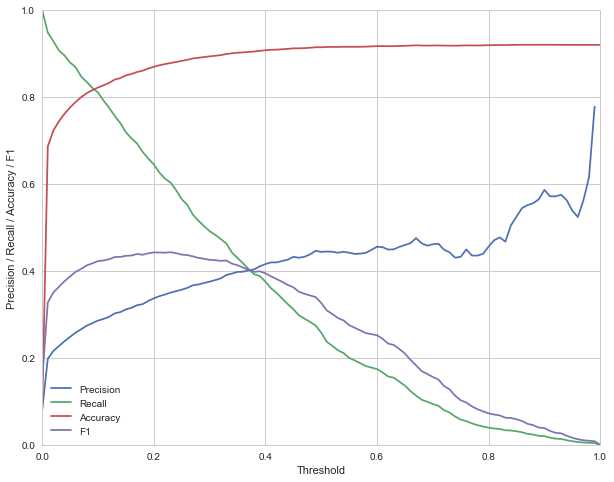

In [20]:
rf_cols =  ['loan_amount',  'latitude', 'longitude',
            'borrower_count', 'percentage_women', 
            'sector_percent_expired',
            'country_percent_expired', 'country_total_loans', 
            'terms_repayment_term', 'tag_text_fund_prob', 'knn_pred']

        
rf_model = RandomForestClassifier(n_estimators=1000)
rf_model.fit(X_train.loc[:, rf_cols], y_train)

# predict class labels for the test set
y_test_pred_proba_rf = rf_model.predict_proba(X_test.loc[:, rf_cols])[:, 1]

model_name_rf = 'Random Forest'
recallvec_rf, precisionvec_rf, threshvec_rf, auc_score_rf, l_loss_rf = print_metrics(
    model_name_rf, y_test, y_test_pred_proba_rf)

order_zip_coeff(rf_cols, rf_model.feature_importances_)


# AUC:  0.89007825825
# Log Loss:  0.242673152133

## Gradient Boosting Classifier

---  Gradient Boosting Classifier  ---
AUC:  0.905530341322
Log Loss:  0.185385176297


[(0, ('loan_amount', 0.2131788787914875)),
 (1, ('terms_repayment_term', 0.16376332024374921)),
 (2, ('sector_percent_expired', 0.13709527701587543)),
 (3, ('country_total_loans', 0.11210074488926151)),
 (4, ('country_percent_expired', 0.10126658847081788)),
 (5, ('tag_text_fund_prob', 0.078514360319682744)),
 (6, ('percentage_women', 0.05870326466066525)),
 (7, ('longitude', 0.058682407557531631)),
 (8, ('latitude', 0.047599473652390777)),
 (9, ('is_risky_country', 0.016633271323464094)),
 (10, ('borrower_count', 0.012462413075074008))]

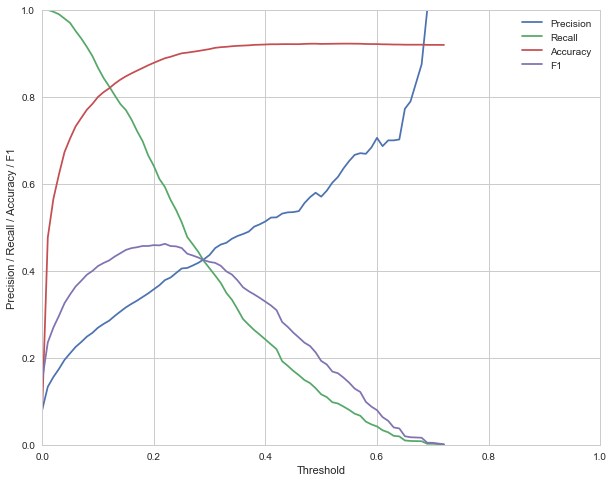

In [21]:
gb_cols =  ['loan_amount',  'latitude', 'longitude',
            'borrower_count', 'percentage_women', 
            'sector_percent_expired', 
            'country_percent_expired', 'country_total_loans', 
            'terms_repayment_term', 'tag_text_fund_prob']

gb_model = GradientBoostingClassifier()
gb_model.fit(X_train.loc[:, gb_cols], y_train)
y_test_pred_proba_gb = gb_model.predict_proba(X_test.loc[:, gb_cols])[:, 1]

model_name_gb = 'Gradient Boosting Classifier'
recallvec_gb, precisionvec_gb, threshvec_gb, auc_score_gb, l_loss_gb = print_metrics (
    model_name_gb, y_test, y_test_pred_proba_gb)

order_zip_coeff(gb_cols, gb_model.feature_importances_)

# AUC:  0.905530341322
# Log Loss:  0.185385182304


## Logistic Regression

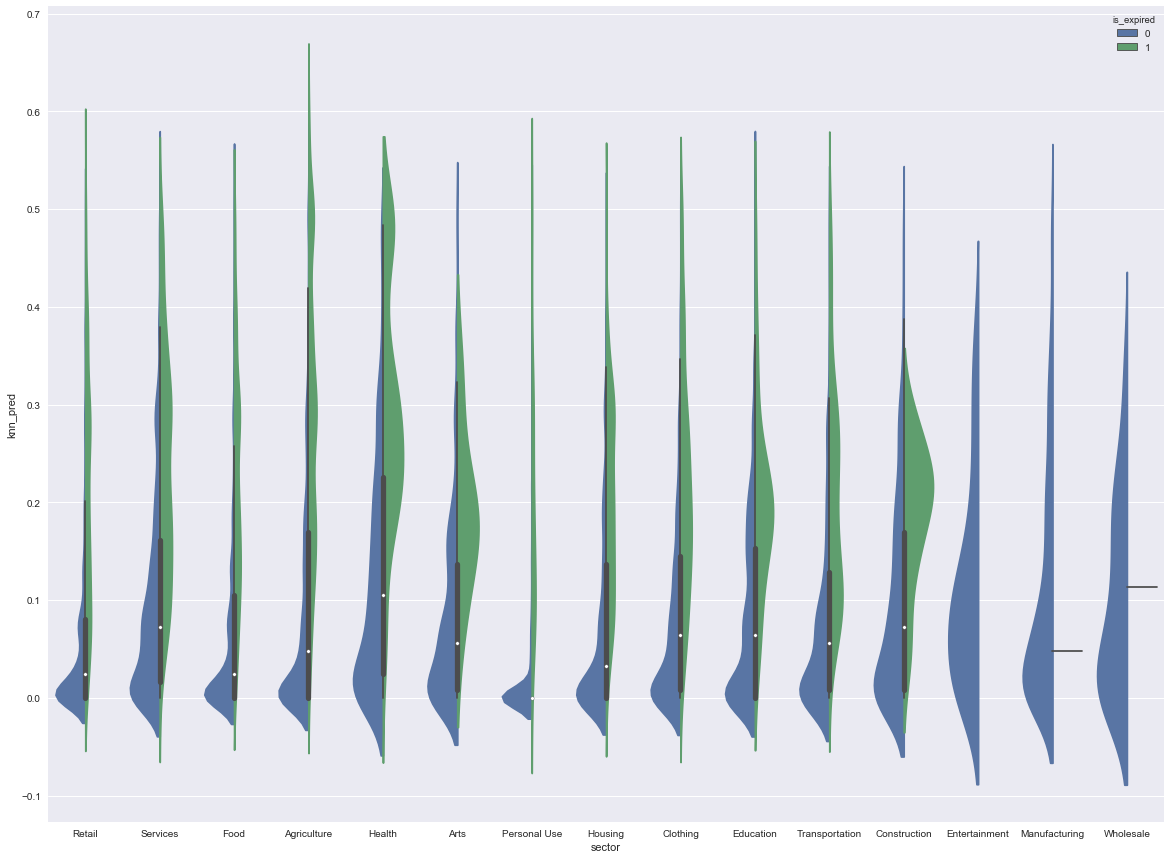

In [106]:
sns.set(rc={"figure.figsize": (20, 15)})
train_Xy = pd.concat([X_train, pd.DataFrame({'is_expired': y_train})], axis=1)
sns.violinplot(x="sector", y="knn_pred", hue="is_expired", data=train_Xy, split=True);

In [64]:
# train_Xy = pd.concat([X_train, pd.DataFrame({'is_expired': y_train})], axis=1)
# sns.violinplot(x="is_expired", y="percentage_women", hue="is_expired", data=train_Xy, split=True);

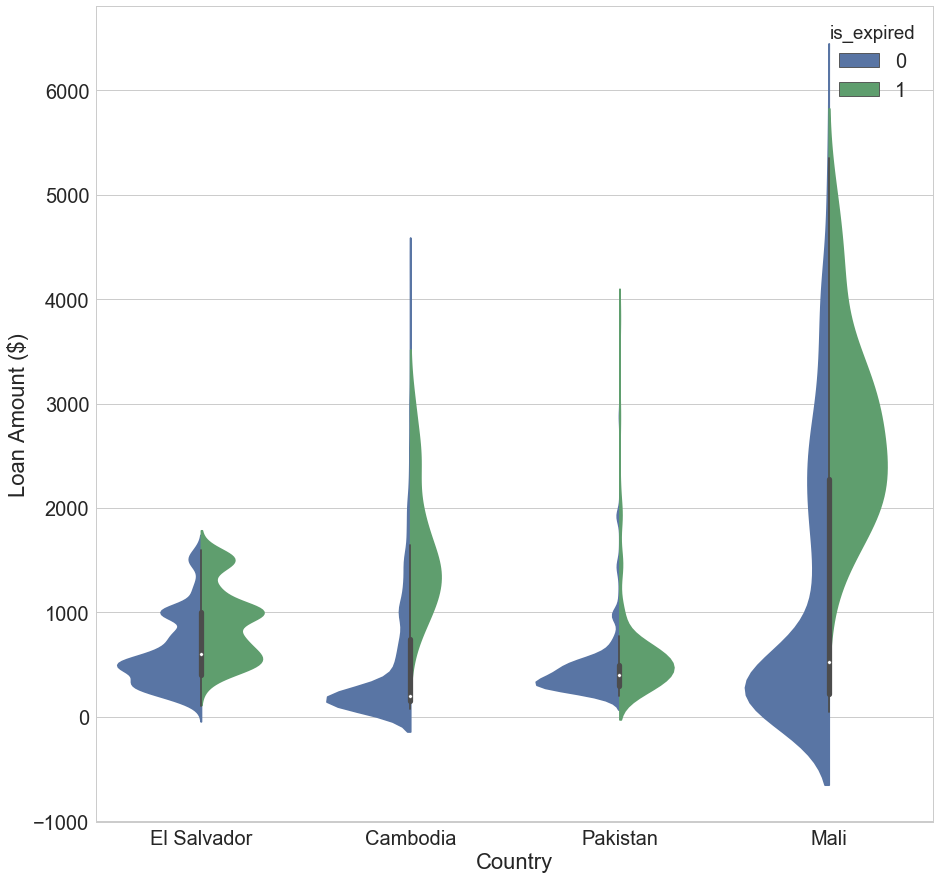

In [85]:
sns.set(rc={"figure.figsize": (15, 15)}, font_scale=2, style="whitegrid")
train_Xy_country = train_Xy.loc[(train_Xy.country == 'Pakistan') | (train_Xy.country == 'Mali') 
                                | (train_Xy.country == 'Cambodia') | (train_Xy.country == 'El Salvador'), :]
sns.violinplot(x="country", y="loan_amount", hue="is_expired", data=train_Xy_country, split=True);
plt.ylabel('Loan Amount ($)')
plt.xlabel('Country')

---  Logistic Regression  ---
AUC:  0.859134654217
Log Loss:  0.218151025712


/Users/nanawu/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nanawu/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


[(0, ('knn_pred', 0.82330768254163211)),
 (1, ('sector_percent_expired', 0.39761249548426342)),
 (2, ('terms_repayment_term', 0.17057916935450798)),
 (3, ('tag_text_fund_prob', 0.15108043159636841)),
 (4, ('is_risky_country', 0.13232157401213374)),
 (5, ('loan_amount', 0.093324999061520614)),
 (6, ('percentage_women', -0.30699985244155142))]

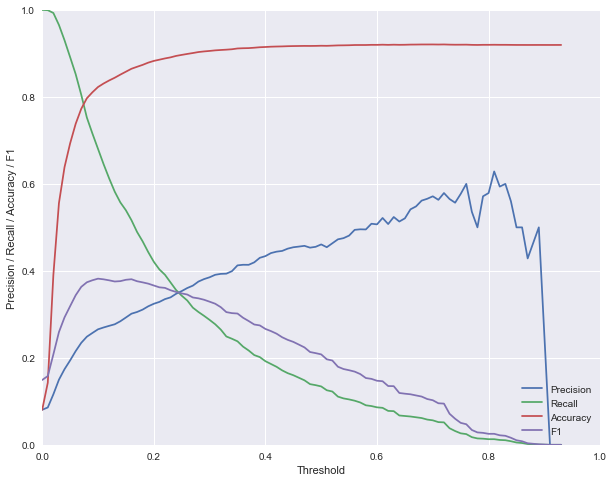

In [24]:
lr_cols = ['loan_amount', 'percentage_women',
           'knn_pred', 'sector_percent_expired',
           'terms_repayment_term', 'tag_text_fund_prob']

std_lr = StandardScaler()
std_lr.fit(X_train.loc[:, lr_cols])

X_std_train_lr = std_lr.transform(X_train.loc[:, lr_cols])
X_std_test_lr = std_lr.transform(X_test.loc[:, lr_cols])

lr_model = LogisticRegression()
lr_model.fit(X_std_train_lr, y_train)
y_test_pred_proba_lr = lr_model.predict_proba(X_std_test_lr)[:, 1]

model_name_lr = 'Logistic Regression'
recallvec_lr, precisionvec_lr, threshvec_lr, auc_score_lr, l_loss_lr = print_metrics (
    model_name_lr, y_test, y_test_pred_proba_lr)

order_zip_coeff(lr_cols, lr_model.coef_[0])



## Ensemble Method

---  Ensemble  ---
AUC:  0.895279289455
Log Loss:  0.195623940393


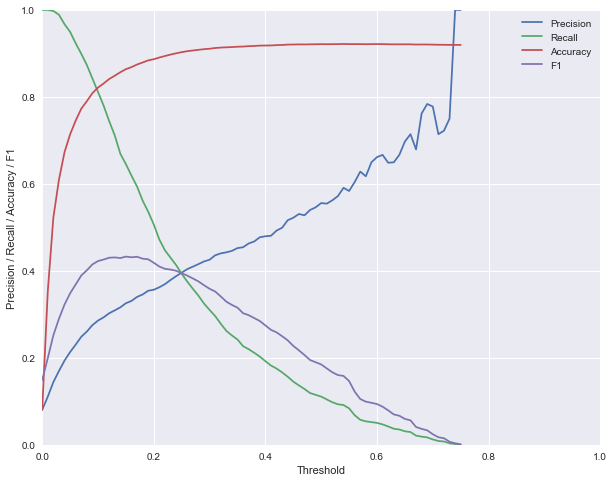

In [25]:
y_test_pred_proba_ensemble = (y_test_pred_proba_lr * y_test_pred_proba_gb)**(.5)

model_name_ensemble = 'Ensemble'
recallvec_ensemble, precisionvec_ensemble, threshvec_ensemble, auc_score_ensemble, l_loss_ensemble = print_metrics (
    model_name_ensemble, y_test, y_test_pred_proba_ensemble)

## Metrics

In [26]:
# Baseline Metrics
percentage_pos = np.mean(y_train)
percentage_neg = 1 - percentage_pos
baseline_logloss = -1 * ((percentage_pos * np.log(percentage_pos)) + ((1-percentage_neg) * np.log(percentage_neg)))
# starting from low entropy
print('Positive: {}%, Baseline Log Loss: {}'.format(percentage_pos * 100, baseline_logloss))

Positive: 8.053374455161997%, Baseline Log Loss: 0.20963263330049575


### Model Comparisons

,Model,Log Loss,Log Loss / Baseline Log Loss,AUC
0,Baseline,0.209633,1.000000,NaN
1,Gradient Boosting Classifier,0.185385,0.884334,0.905530
2,Random Forest,0.249675,1.191014,0.887730
3,Logistic Regression,0.218151,1.040635,0.859135


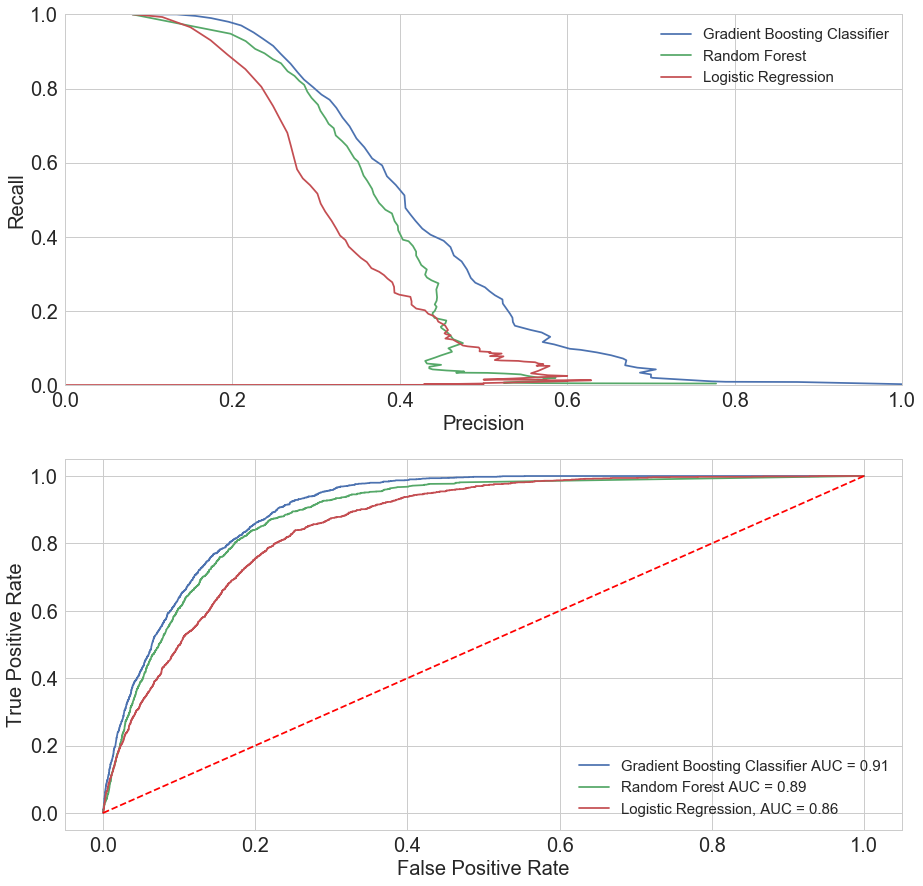

In [63]:
# ROC Curve
fpr_gb, tpr_gb, threshold_gb = roc_curve(y_test, y_test_pred_proba_gb)
fpr_rf, tpr_rf, threshold_rf = roc_curve(y_test, y_test_pred_proba_rf)
fpr_knn, tpr_knn, threshold_knn = roc_curve(y_test, y_test_pred_proba_knn)
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_test, y_test_pred_proba_lr)
fpr_ensemble, tpr_ensemble, threshold_ensemble = roc_curve(y_test, y_test_pred_proba_ensemble)

fig, ax = plt.subplots(2, 1, figsize=(15, 15))

# Precision Recall
ax[0].plot(precisionvec_gb, recallvec_gb, label=model_name_gb)
ax[0].plot(precisionvec_rf, recallvec_rf, label=model_name_rf)
ax[0].plot(precisionvec_lr, recallvec_lr, label=model_name_lr)
# ax[0].plot(precisionvec_knn, recallvec_knn, label=model_name_knn)
# ax[0].plot(precisionvec_ensemble, recallvec_ensemble, label=model_name_ensemble)
ax[0].axis([0, 1, 0, 1])
ax[0].set_xlabel("Precision", fontsize=20)
ax[0].set_ylabel("Recall", fontsize=20)
ax[0].legend(prop={'size': 15})

# ROC Curve
# ax[1].set_title('Receiver Operating Characteristic')
ax[1].plot(fpr_gb, tpr_gb, label = 'Gradient Boosting Classifier AUC = %0.2f' % auc_score_gb)
ax[1].plot(fpr_rf, tpr_rf, label = 'Random Forest AUC = %0.2f' % auc_score_rf)
ax[1].plot(fpr_lr, tpr_lr, label = 'Logistic Regression, AUC = %0.2f' % auc_score_lr)
# ax[1].plot(fpr_knn, tpr_knn, label = 'KNN, K=124, AUC = %0.2f' % auc_score_knn)
# ax[1].plot(fpr_ensemble, tpr_ensemble, label = 'Ensemble, AUC = %0.2f' % auc_score_ensemble)
ax[1].legend(loc = 'lower right', prop={'size': 15})
ax[1].plot([0, 1], [0, 1],'r--')
ax[1].set_ylabel('True Positive Rate', fontsize=20)
ax[1].set_xlabel('False Positive Rate', fontsize=20)

# Other Metrics:
df_metrics = pd.DataFrame({'Model': ['Baseline', model_name_gb, model_name_rf, 
                                     model_name_lr, 
#                                      model_name_knn, model_name_ensemble
                                    ],
                           'Log Loss': [baseline_logloss, l_loss_gb, l_loss_rf, 
                                        l_loss_lr, 
#                                         l_loss_knn, l_loss_ensemble
                                       ],
                           'Log Loss / Baseline Log Loss': [
                               1, (l_loss_gb / baseline_logloss),
                               (l_loss_rf / baseline_logloss), (l_loss_lr / baseline_logloss),
#                                (l_loss_knn / baseline_logloss), (l_loss_ensemble / baseline_logloss)
                           ],
                           'AUC': [np.nan, auc_score_gb, auc_score_rf, auc_score_lr,
#                                    auc_score_knn, auc_score_ensemble
                                  ]})
df_metrics[['Model', 'Log Loss', 'Log Loss / Baseline Log Loss', 'AUC']]

In [37]:
df[df.status == 'expired']['id'].map(lambda loan_id: 'https://www.kiva.org/lend/' + str(loan_id))


276      https://www.kiva.org/lend/1033039
378      https://www.kiva.org/lend/1033678
389      https://www.kiva.org/lend/1034035
502      https://www.kiva.org/lend/1034584
504      https://www.kiva.org/lend/1034593
559      https://www.kiva.org/lend/1035139
799      https://www.kiva.org/lend/1036652
824      https://www.kiva.org/lend/1036910
831      https://www.kiva.org/lend/1036923
845      https://www.kiva.org/lend/1037031
885      https://www.kiva.org/lend/1037207
901      https://www.kiva.org/lend/1037260
903      https://www.kiva.org/lend/1037262
904      https://www.kiva.org/lend/1037263
918      https://www.kiva.org/lend/1037289
962      https://www.kiva.org/lend/1037410
966      https://www.kiva.org/lend/1037414
973      https://www.kiva.org/lend/1037422
992      https://www.kiva.org/lend/1037441
998      https://www.kiva.org/lend/1037447
1009     https://www.kiva.org/lend/1037458
1039     https://www.kiva.org/lend/1037488
1048     https://www.kiva.org/lend/1037497
1066     ht